# LSTM Multi-task

In [1]:
import torch
import torch.nn as nn
from utils.seq_data_loader import LoanSimDataset, collate_fn
from torch.utils.data import DataLoader
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Device setup
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
scale_columns = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
]

features = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
]

---

In [4]:
state_targets = [
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
]

installment_targets = [
    "installment_done",
]

loan_targets = [
    "loan_done",
]

recovery_rate_targets = [
    "recovery_rate_weighted",
]

full_targets = (
    state_targets + installment_targets + loan_targets + recovery_rate_targets
)

In [5]:
train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=full_targets,
    group="train",
)


# use the test data as validation data
val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=full_targets,
    group="test",  # read the test data
)

train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


val_dataloader = DataLoader(
    val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

------------ Creating Sequences ------------


------------ Creating Sequences ------------


## Hyper Parameters

In [6]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(full_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100

# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

"""
This model is a simple-task LSTM model that takes in a sequence of input (21 features) and 7 outputs (next state prediction) a sequence of output

Model Structure: 1 Layer LSTM + 1 FC for State Prediction + 1 FC for Installment Prediction + 1 FC for Loan Prediction + 1 FC for Recovery Rate Prediction
"""


class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        len_state_targets=7,
        len_installment_targets=1,
        len_loan_targets=1,
        len_recovery_rate_targets=1,
    ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # ------------------------------------
        # LSTM Layer as a feature extractor
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # ------------------------------------
        # MLP for prediction (state, installment, loan, recovery rate)
        self.state_pred = nn.Linear(hidden_size, len_state_targets)
        self.installment_pred = nn.Sequential(
            nn.Linear(hidden_size, len_installment_targets), nn.Sigmoid()
        )
        self.loan_pred = nn.Sequential(
            nn.Linear(hidden_size, len_loan_targets), nn.Sigmoid()
        )
        self.recovery_rate_pred = nn.Sequential(
            nn.Linear(hidden_size, len_recovery_rate_targets), nn.ReLU()
        )

    def forward(self, x, lengths):  # Accepts raw input and lengths
        # Pack sequence
        packed_x = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # Pass through MLP
        # out = self.mlp(lstm_out)
        state_out = self.state_pred(lstm_out)
        installment_out = self.installment_pred(lstm_out)
        loan_out = self.loan_pred(lstm_out)
        recovery_rate_out = self.recovery_rate_pred(lstm_out)
        return state_out, installment_out, loan_out, recovery_rate_out

In [8]:
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [9]:
# regression question, so use MSE as the Loss function
mse_criterion = nn.MSELoss()
# Binary Cross Entropy Loss for the binary classification task
bce_criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()

Run All the Code Above before the Model Training!

## Before Training

---

## Multi-task LSTM model 1
* Each task has the same weight

In [11]:
from sklearn.metrics import f1_score, accuracy_score


train_losses = []
val_losses = []

traing_state_loss_list = []
training_installment_loss_list = []
training_loan_loss_list = []
training_recovery_rate_loss_list = []

val_state_loss_list = []
val_installment_loss_list = []
val_loan_loss_list = []
val_recovery_rate_loss_list = []

val_loan_f1_list = []
val_installment_f1_list = []

for epoch in range(num_epochs):
    # chage the model to training mode to enable dropout
    model.train()
    running_loss = 0.0
    traing_state_loss = 0.0
    training_installment_loss = 0.0
    training_loan_loss = 0.0
    training_recovery_rate_loss = 0.0

    print("------------------------------------")
    # console.print(Markdown("---"))
    print(f"Epoch {epoch}")
    # console.print("Epoch", epoch, style="bold green")

    for inputs, targets, lengths in train_dataloader:

        input: torch.Tensor
        targets: torch.Tensor

        optimizer.zero_grad()

        inputs = inputs.to(device)
        state_targets = targets[:, :, :7].to(device)
        installment_targets = targets[:, :, 7:8].to(device)
        loan_targets = targets[:, :, 8:9].to(device)
        recovery_rate_targets = targets[:, :, 9:].to(device)
        # print('This is the state targets')
        # print(state_targets.shape)
        # print('This is the installment targets')
        # print(installment_targets.shape)
        # print('This is the loan targets')
        # print(loan_targets.shape)
        # print('This is the recovery rate targets')
        # print(recovery_rate_targets.shape)

        # Forward pass, calculate the loss
        state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
            inputs, lengths
        )
        state_loss = mse_criterion(state_pred, state_targets)
        installment_loss = bce_criterion(installment_pred, installment_targets)
        loan_loss = bce_criterion(loan_pred, loan_targets)
        recovery_rate_loss = mse_criterion(recovery_rate_pred, recovery_rate_targets)

        loss = state_loss + installment_loss + loan_loss + recovery_rate_loss

        loss.backward()
        optimizer.step()
        # print(f"Loss: {loss.item()}")
        running_loss += loss.item()
        traing_state_loss += state_loss.item()
        training_installment_loss += installment_loss.item()
        training_loan_loss += loan_loss.item()
        training_recovery_rate_loss += recovery_rate_loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    traing_state_loss = traing_state_loss / len(train_dataloader)
    training_installment_loss = training_installment_loss / len(train_dataloader)
    training_loan_loss = training_loan_loss / len(train_dataloader)
    training_recovery_rate_loss = training_recovery_rate_loss / len(train_dataloader)

    print(f"Training Loss: {avg_train_loss}")
    print(f"Training State Loss: {traing_state_loss}")
    print(f"Training Installment Loss: {training_installment_loss}")
    print(f"Training Loan Loss: {training_loan_loss}")
    print(f"Training Recovery Rate Loss: {training_recovery_rate_loss}")
    train_losses.append(avg_train_loss)
    traing_state_loss_list.append(traing_state_loss)
    training_installment_loss_list.append(training_installment_loss)
    training_loan_loss_list.append(training_loan_loss)
    training_recovery_rate_loss_list.append(training_recovery_rate_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_state_loss = 0.0
        val_installment_loss = 0.0
        val_loan_loss = 0.0
        val_recovery_rate_loss = 0.0
        # prediction and target lists for f1 score
        all_loan_preds = []
        all_loan_targets = []
        all_installment_preds = []
        all_installment_targets = []

        for inputs, targets, lengths in val_dataloader:
            inputs = inputs.to(device)
            state_targets = targets[:, :, :7].to(device)
            installment_targets = targets[:, :, 7:8].to(device)
            loan_targets = targets[:, :, 8:9].to(device)
            recovery_rate_targets = targets[:, :, 9:].to(device)

            state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
                inputs, lengths
            )
            state_loss = mse_criterion(state_pred, state_targets)
            installment_loss = bce_criterion(installment_pred, installment_targets)
            loan_loss = bce_criterion(loan_pred, loan_targets)
            recovery_rate_loss = mse_criterion(
                recovery_rate_pred, recovery_rate_targets
            )

            loss = state_loss + installment_loss + loan_loss + recovery_rate_loss

            val_loss += loss.item()
            val_state_loss += state_loss.item()
            val_installment_loss += installment_loss.item()
            val_loan_loss += loan_loss.item()
            val_recovery_rate_loss += recovery_rate_loss.item()

            # loan_preds = loan_pred.squeeze(-1)
            # loan_preds = (loan_preds > 0.5).long()

            # for i in range(len(loan_preds)):
            #     seq_len = lengths[i].item()
            #     all_loan_preds.append(loan_preds[i].item())
            #     all_loan_targets.append(loan_targets[i].item())

            loan_preds = (loan_pred > 0.5).int().cpu().numpy().flatten()
            installment_preds = (installment_pred > 0.5).int().cpu().numpy().flatten()
            loan_targets = loan_targets.cpu().numpy().flatten()
            installment_targets = installment_targets.cpu().numpy().flatten()

        all_loan_preds.extend(loan_preds)
        all_loan_targets.extend(loan_targets)
        all_installment_preds.extend(installment_preds)
        all_installment_targets.extend(installment_targets)

        avg_val_loss = val_loss / len(val_dataloader)
        val_state_loss = val_state_loss / len(val_dataloader)
        val_installment_loss = val_installment_loss / len(val_dataloader)
        val_loan_loss = val_loan_loss / len(val_dataloader)
        val_recovery_rate_loss = val_recovery_rate_loss / len(val_dataloader)

        loan_f1 = f1_score(all_loan_targets, all_loan_preds, zero_division=0)
        installment_f1 = f1_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        loan_acc = accuracy_score(all_loan_targets, all_loan_preds)
        installment_acc = accuracy_score(all_installment_targets, all_installment_preds)

        print(f"Validation Loss: {avg_val_loss}")
        print(f"Validation State Loss: {val_state_loss}")
        print(f"Validation Installment Loss: {val_installment_loss}")
        print(f"Validation Loan Loss: {val_loan_loss}")
        print(f"Validation Recovery Rate Loss: {val_recovery_rate_loss}")
        print()
        print(f"Validation Loan F1: {loan_f1}")
        print(f"Validation Installment F1: {installment_f1}")
        print(f"Validation Loan Accuracy: {loan_acc}")
        print(f"Validation Installment Accuracy: {installment_acc}")
        print()
        val_losses.append(avg_val_loss)
        val_state_loss_list.append(val_state_loss)
        val_installment_loss_list.append(val_installment_loss)
        val_loan_loss_list.append(val_loan_loss)
        val_recovery_rate_loss_list.append(val_recovery_rate_loss)

        # Early Stopping Check: If the validation loss is not decreasing for 'patience' epochs, stop training
        model_save_path = "./Out/LSTM_multi_same_weight.pth"
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # save the model
            torch.save(model.state_dict(), model_save_path)
            print("This training checkpoint has been saved!")
        else:
            counter += 1
            if counter >= patience:
                # print(
                #     f"Early stopping at epoch {epoch}, the best validation loss is {best_val_loss}"
                # )
                console.print(
                    "Early stopping at epoch",
                    epoch,
                    "the best validation loss is ",
                    best_val_loss,
                    "The model has been saved in",
                    model_save_path,
                    style="bold green",
                )
                break

------------------------------------
Epoch 0
Training Loss: 1.3200471563910952
Training State Loss: 0.22526524886869045
Training Installment Loss: 0.6430369322093166
Training Loan Loss: 0.4486634773867471
Training Recovery Rate Loss: 0.003081499634854667
Validation Loss: 1.0755413242361762
Validation State Loss: 0.13785302029414612
Validation Installment Loss: 0.5650796917351809
Validation Loan Loss: 0.3699002753604542
Validation Recovery Rate Loss: 0.002708339127076959

Validation Loan F1: 0.3
Validation Installment F1: 0.7717391304347826
Validation Loan Accuracy: 0.9635416666666666
Validation Installment Accuracy: 0.890625

This training checkpoint has been saved!
------------------------------------
Epoch 1
Training Loss: 0.932718143475299
Training State Loss: 0.10771095970341442
Training Installment Loss: 0.481731402706735
Training Loan Loss: 0.34070638487381594
Training Recovery Rate Loss: 0.002569395857233535
Validation Loss: 0.8158842948350039
Validation State Loss: 0.0843906147

Early stopping at epoch 92 the best validation loss is  0.09106697497720068 The model has been saved in 
./Out/LSTM_multi_same_weight.pth

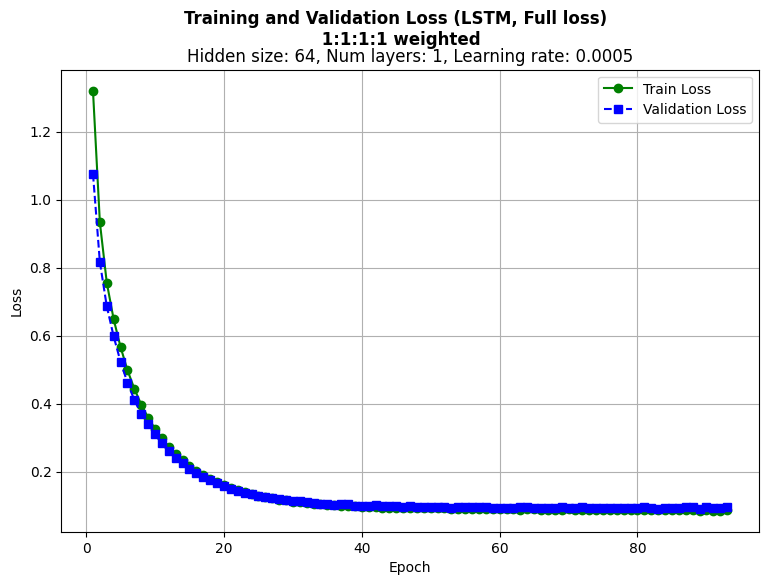

In [31]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(9, 6))
plt.plot(
    epochs,
    train_losses,
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="Green",
)
plt.plot(
    epochs,
    val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="blue",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Full loss) \n 1:1:1:1 weighted", weight="bold", size=12)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

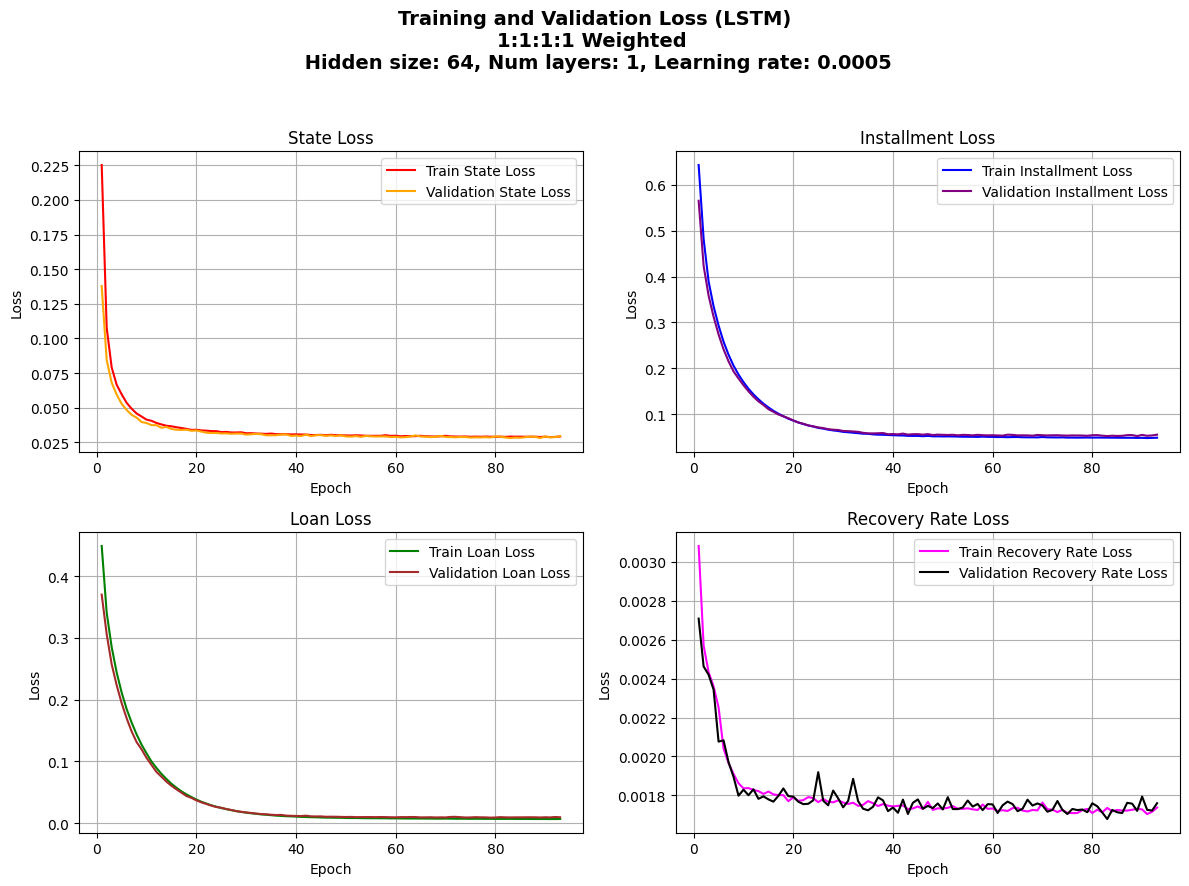

In [37]:
# a plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# plot 1: traing_state_loss_list and val_state_loss_list
axs[0, 0].plot(epochs, traing_state_loss_list, label="Train State Loss", color="red")
axs[0, 0].plot(epochs, val_state_loss_list, label="Validation State Loss", color="orange")
axs[0, 0].set_title("State Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# plot 2: training_installment_loss_list and val_installment_loss_list
axs[0, 1].plot(
    epochs, training_installment_loss_list, label="Train Installment Loss", color="blue"
)
axs[0, 1].plot(
    epochs, val_installment_loss_list, label="Validation Installment Loss", color="purple"
)
axs[0, 1].set_title("Installment Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[0, 1].grid(True)

# plot 3: training_loan_loss_list and val_loan_loss_list
axs[1, 0].plot(epochs, training_loan_loss_list, label="Train Loan Loss", color="green")
axs[1, 0].plot(epochs, val_loan_loss_list, label="Validation Loan Loss", color="brown")
axs[1, 0].set_title("Loan Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()
axs[1, 0].grid(True)

# plot 4: training_recovery_rate_loss_list and val_recovery_rate_loss_list
axs[1, 1].plot(
    epochs, training_recovery_rate_loss_list, label="Train Recovery Rate Loss", color="magenta"
)
axs[1, 1].plot(
    epochs, val_recovery_rate_loss_list, label="Validation Recovery Rate Loss", color="black"
)
axs[1, 1].set_title("Recovery Rate Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
axs[1, 1].grid(True)

# add model parameters to the subtitle
suptitle = f"1:1:1:1 Weighted \n Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
plt.suptitle("Training and Validation Loss (LSTM)" + '\n' + suptitle, weight="bold", size=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

## Multi-task LSTM model 2
$$ loss = loss_{state}+loss_{installment}+loss_{loan}+10*loss_{recovery\ rate} $$

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


train_losses = []
val_losses = []

traing_state_loss_list = []
training_installment_loss_list = []
training_loan_loss_list = []
training_recovery_rate_loss_list = []

val_state_loss_list = []
val_installment_loss_list = []
val_loan_loss_list = []
val_recovery_rate_loss_list = []

val_loan_f1_list = []
val_installment_f1_list = []

for epoch in range(num_epochs):
    # chage the model to training mode to enable dropout
    model.train()
    running_loss = 0.0
    traing_state_loss = 0.0
    training_installment_loss = 0.0
    training_loan_loss = 0.0
    training_recovery_rate_loss = 0.0

    print("------------------------------------")
    # console.print(Markdown("---"))
    print(f"Epoch {epoch}")
    # console.print("Epoch", epoch, style="bold green")

    for inputs, targets, lengths in train_dataloader:

        input: torch.Tensor
        targets: torch.Tensor

        optimizer.zero_grad()

        inputs = inputs.to(device)
        state_targets = targets[:, :, :7].to(device)
        installment_targets = targets[:, :, 7:8].to(device)
        loan_targets = targets[:, :, 8:9].to(device)
        recovery_rate_targets = targets[:, :, 9:].to(device)
        # print('This is the state targets')
        # print(state_targets.shape)
        # print('This is the installment targets')
        # print(installment_targets.shape)
        # print('This is the loan targets')
        # print(loan_targets.shape)
        # print('This is the recovery rate targets')
        # print(recovery_rate_targets.shape)

        # Forward pass, calculate the loss
        state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
            inputs, lengths
        )
        state_loss = mse_criterion(state_pred, state_targets)
        installment_loss = bce_criterion(installment_pred, installment_targets)
        loan_loss = bce_criterion(loan_pred, loan_targets)
        recovery_rate_loss = mse_criterion(recovery_rate_pred, recovery_rate_targets)

        loss = state_loss + installment_loss + loan_loss + 10 * recovery_rate_loss

        loss.backward()
        optimizer.step()
        # print(f"Loss: {loss.item()}")
        running_loss += loss.item()
        traing_state_loss += state_loss.item()
        training_installment_loss += installment_loss.item()
        training_loan_loss += loan_loss.item()
        training_recovery_rate_loss += recovery_rate_loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    traing_state_loss = traing_state_loss / len(train_dataloader)
    training_installment_loss = training_installment_loss / len(train_dataloader)
    training_loan_loss = training_loan_loss / len(train_dataloader)
    training_recovery_rate_loss = training_recovery_rate_loss / len(train_dataloader)

    print(f"Training Loss: {avg_train_loss}")
    print(f"Training State Loss: {traing_state_loss}")
    print(f"Training Installment Loss: {training_installment_loss}")
    print(f"Training Loan Loss: {training_loan_loss}")
    print(f"Training Recovery Rate Loss: {training_recovery_rate_loss}")
    train_losses.append(avg_train_loss)
    traing_state_loss_list.append(traing_state_loss)
    training_installment_loss_list.append(training_installment_loss)
    training_loan_loss_list.append(training_loan_loss)
    training_recovery_rate_loss_list.append(training_recovery_rate_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_state_loss = 0.0
        val_installment_loss = 0.0
        val_loan_loss = 0.0
        val_recovery_rate_loss = 0.0
        # prediction and target lists for f1 score
        all_loan_preds = []
        all_loan_targets = []
        all_installment_preds = []
        all_installment_targets = []

        for inputs, targets, lengths in val_dataloader:
            inputs = inputs.to(device)
            state_targets = targets[:, :, :7].to(device)
            installment_targets = targets[:, :, 7:8].to(device)
            loan_targets = targets[:, :, 8:9].to(device)
            recovery_rate_targets = targets[:, :, 9:].to(device)

            state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
                inputs, lengths
            )
            state_loss = mse_criterion(state_pred, state_targets)
            installment_loss = bce_criterion(installment_pred, installment_targets)
            loan_loss = bce_criterion(loan_pred, loan_targets)
            recovery_rate_loss = mse_criterion(
                recovery_rate_pred, recovery_rate_targets
            )

            loss = state_loss + installment_loss + loan_loss + recovery_rate_loss

            val_loss += loss.item()
            val_state_loss += state_loss.item()
            val_installment_loss += installment_loss.item()
            val_loan_loss += loan_loss.item()
            val_recovery_rate_loss += recovery_rate_loss.item()

            # loan_preds = loan_pred.squeeze(-1)
            # loan_preds = (loan_preds > 0.5).long()

            # for i in range(len(loan_preds)):
            #     seq_len = lengths[i].item()
            #     all_loan_preds.append(loan_preds[i].item())
            #     all_loan_targets.append(loan_targets[i].item())

            loan_preds = (loan_pred > 0.5).int().cpu().numpy().flatten()
            installment_preds = (installment_pred > 0.5).int().cpu().numpy().flatten()
            loan_targets = loan_targets.cpu().numpy().flatten()
            installment_targets = installment_targets.cpu().numpy().flatten()

        all_loan_preds.extend(loan_preds)
        all_loan_targets.extend(loan_targets)
        all_installment_preds.extend(installment_preds)
        all_installment_targets.extend(installment_targets)

        avg_val_loss = val_loss / len(val_dataloader)
        val_state_loss = val_state_loss / len(val_dataloader)
        val_installment_loss = val_installment_loss / len(val_dataloader)
        val_loan_loss = val_loan_loss / len(val_dataloader)
        val_recovery_rate_loss = val_recovery_rate_loss / len(val_dataloader)

        loan_f1 = f1_score(all_loan_targets, all_loan_preds, zero_division=0)
        installment_f1 = f1_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        loan_acc = accuracy_score(all_loan_targets, all_loan_preds)
        installment_acc = accuracy_score(all_installment_targets, all_installment_preds)

        print(f"Validation Loss: {avg_val_loss}")
        print(f"Validation State Loss: {val_state_loss}")
        print(f"Validation Installment Loss: {val_installment_loss}")
        print(f"Validation Loan Loss: {val_loan_loss}")
        print(f"Validation Recovery Rate Loss: {val_recovery_rate_loss}")
        print()
        print(f"Validation Loan F1: {loan_f1}")
        print(f"Validation Installment F1: {installment_f1}")
        print(f"Validation Loan Accuracy: {loan_acc}")
        print(f"Validation Installment Accuracy: {installment_acc}")
        print()
        val_losses.append(avg_val_loss)
        val_state_loss_list.append(val_state_loss)
        val_installment_loss_list.append(val_installment_loss)
        val_loan_loss_list.append(val_loan_loss)
        val_recovery_rate_loss_list.append(val_recovery_rate_loss)

        # Early Stopping Check: If the validation loss is not decreasing for 'patience' epochs, stop training
        model_save_path = "./Out/LSTM_multi_10_rec_weight.pth"
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # save the model
            torch.save(model.state_dict(), model_save_path)
            print("This training checkpoint has been saved!")
        else:
            counter += 1
            if counter >= patience:
                # print(
                #     f"Early stopping at epoch {epoch}, the best validation loss is {best_val_loss}"
                # )
                console.print(
                    "Early stopping at epoch",
                    epoch,
                    "the best validation loss is ",
                    best_val_loss,
                    "The model has been saved in",
                    model_save_path,
                    style="bold green",
                )
                break

------------------------------------
Epoch 0


Training Loss: 1.3561895042657852
Training State Loss: 0.23203723987906563
Training Installment Loss: 0.5972920050274353
Training Loan Loss: 0.4997376021073789
Training Recovery Rate Loss: 0.0027122656554601403
Validation Loss: 1.0756964710625736
Validation State Loss: 0.14132124981419605
Validation Installment Loss: 0.5241513387723402
Validation Loan Loss: 0.4076813039454547
Validation Recovery Rate Loss: 0.002542581843127581

Validation Loan F1: 0.3
Validation Installment F1: 0.8252427184466019
Validation Loan Accuracy: 0.965
Validation Installment Accuracy: 0.91

This training checkpoint has been saved!
------------------------------------
Epoch 1
Training Loss: 0.9588015455068374
Training State Loss: 0.11321698450388348
Training Installment Loss: 0.4456249968129761
Training Loan Loss: 0.375959968992642
Training Recovery Rate Loss: 0.002399959483561676
Validation Loss: 0.8205218829891898
Validation State Loss: 0.09167518568309871
Validation Installment Loss: 0.39047930525107816
Vali

Early stopping at epoch 78 the best validation loss is  0.09037350262091919 The model has been saved in 
./Out/LSTM_multi_10_rec_weight.pth

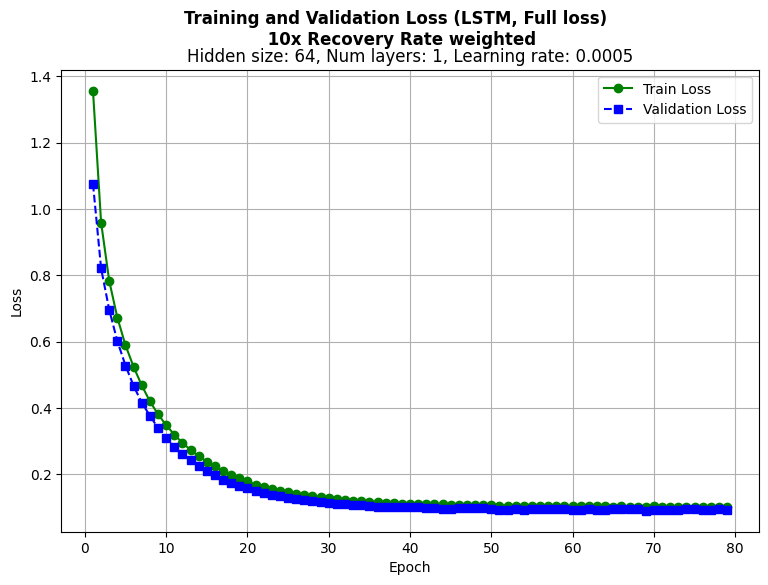

In [50]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(9, 6))
plt.plot(
    epochs,
    train_losses,
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="Green",
)
plt.plot(
    epochs,
    val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="blue",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Full loss) \n 10x Recovery Rate weighted", weight="bold", size=12)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

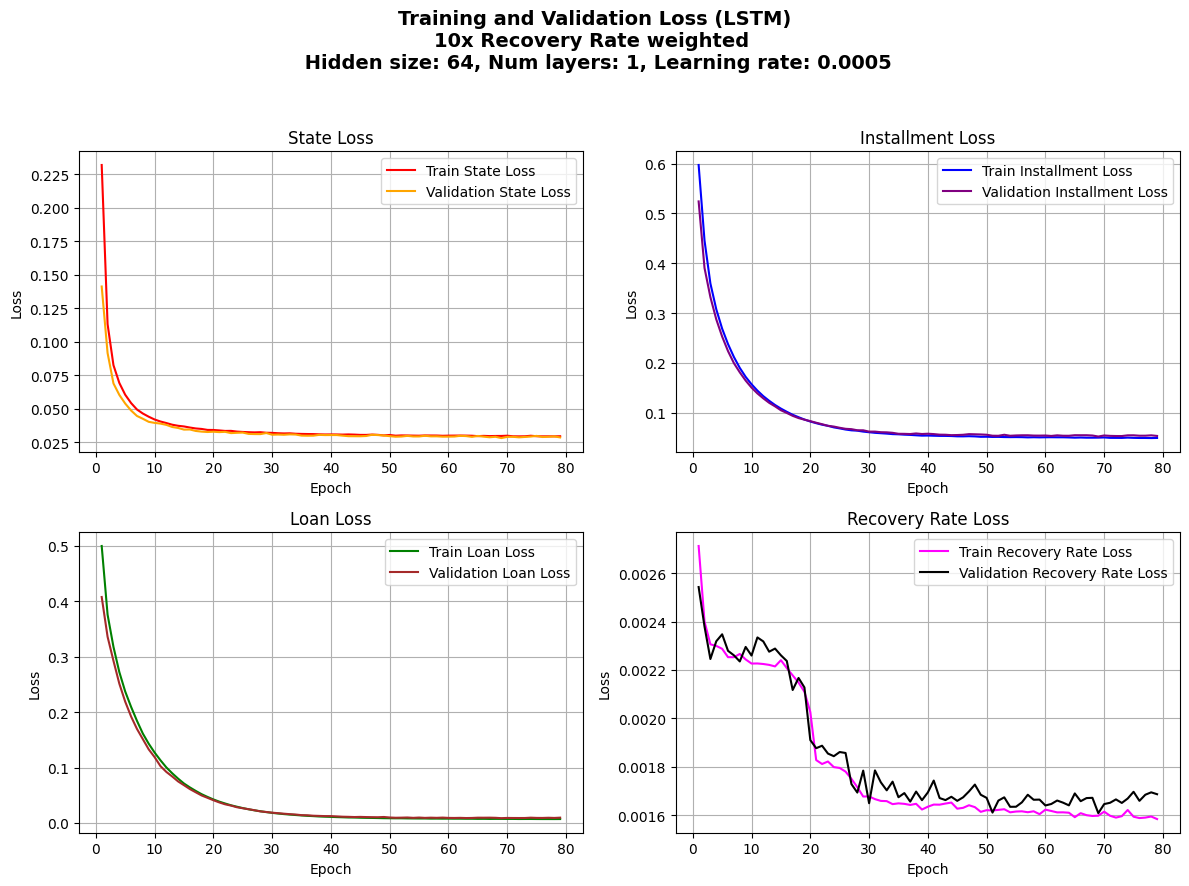

In [51]:
# a plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# plot 1: traing_state_loss_list and val_state_loss_list
axs[0, 0].plot(epochs, traing_state_loss_list, label="Train State Loss", color="red")
axs[0, 0].plot(epochs, val_state_loss_list, label="Validation State Loss", color="orange")
axs[0, 0].set_title("State Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# plot 2: training_installment_loss_list and val_installment_loss_list
axs[0, 1].plot(
    epochs, training_installment_loss_list, label="Train Installment Loss", color="blue"
)
axs[0, 1].plot(
    epochs, val_installment_loss_list, label="Validation Installment Loss", color="purple"
)
axs[0, 1].set_title("Installment Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[0, 1].grid(True)

# plot 3: training_loan_loss_list and val_loan_loss_list
axs[1, 0].plot(epochs, training_loan_loss_list, label="Train Loan Loss", color="green")
axs[1, 0].plot(epochs, val_loan_loss_list, label="Validation Loan Loss", color="brown")
axs[1, 0].set_title("Loan Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()
axs[1, 0].grid(True)

# plot 4: training_recovery_rate_loss_list and val_recovery_rate_loss_list
axs[1, 1].plot(
    epochs, training_recovery_rate_loss_list, label="Train Recovery Rate Loss", color="magenta"
)
axs[1, 1].plot(
    epochs, val_recovery_rate_loss_list, label="Validation Recovery Rate Loss", color="black"
)
axs[1, 1].set_title("Recovery Rate Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
axs[1, 1].grid(True)

# add model parameters to the subtitle
suptitle = f"10x Recovery Rate weighted \n Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
plt.suptitle("Training and Validation Loss (LSTM)" + '\n' + suptitle, weight="bold", size=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---

## Mulyi-task LSTM model 3
* Dynamic Weightd Loss

In [12]:
from sklearn.metrics import f1_score, accuracy_score
# initial weights (equally distributed at the beginning)
task_weights = [0.25, 0.25, 0.25, 0.25]

train_losses = []
val_losses = []

traing_state_loss_list = []
training_installment_loss_list = []
training_loan_loss_list = []
training_recovery_rate_loss_list = []

val_state_loss_list = []
val_installment_loss_list = []
val_loan_loss_list = []
val_recovery_rate_loss_list = []

val_loan_f1_list = []
val_installment_f1_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    traing_state_loss = 0.0
    training_installment_loss = 0.0
    training_loan_loss = 0.0
    training_recovery_rate_loss = 0.0

    print("------------------------------------")
    print(f"Epoch {epoch}")

    for inputs, targets, lengths in train_dataloader:
        optimizer.zero_grad()

        inputs = inputs.to(device)
        state_targets = targets[:, :, :7].to(device)
        installment_targets = targets[:, :, 7:8].to(device)
        loan_targets = targets[:, :, 8:9].to(device)
        recovery_rate_targets = targets[:, :, 9:].to(device)

        state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
            inputs, lengths
        )
        state_loss = mse_criterion(state_pred, state_targets)
        installment_loss = bce_criterion(installment_pred, installment_targets)
        loan_loss = bce_criterion(loan_pred, loan_targets)
        recovery_rate_loss = mse_criterion(recovery_rate_pred, recovery_rate_targets)

        # Dynamic weighted loss
        loss = (
            task_weights[0] * state_loss
            + task_weights[1] * installment_loss
            + task_weights[2] * loan_loss
            + task_weights[3] * recovery_rate_loss
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        traing_state_loss += state_loss.item()
        training_installment_loss += installment_loss.item()
        training_loan_loss += loan_loss.item()
        training_recovery_rate_loss += recovery_rate_loss.item()

    # 计算平均训练损失
    avg_train_loss = running_loss / len(train_dataloader)
    traing_state_loss = traing_state_loss / len(train_dataloader)
    training_installment_loss = training_installment_loss / len(train_dataloader)
    training_loan_loss = training_loan_loss / len(train_dataloader)
    training_recovery_rate_loss = training_recovery_rate_loss / len(train_dataloader)

    print(f"Training Loss: {avg_train_loss}")
    print(f"Training State Loss: {traing_state_loss}")
    print(f"Training Installment Loss: {training_installment_loss}")
    print(f"Training Loan Loss: {training_loan_loss}")
    print(f"Training Recovery Rate Loss: {training_recovery_rate_loss}")

    train_losses.append(avg_train_loss)
    traing_state_loss_list.append(traing_state_loss)
    training_installment_loss_list.append(training_installment_loss)
    training_loan_loss_list.append(training_loan_loss)
    training_recovery_rate_loss_list.append(training_recovery_rate_loss)

    # Validation Part
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_state_loss = 0.0
        val_installment_loss = 0.0
        val_loan_loss = 0.0
        val_recovery_rate_loss = 0.0

        all_loan_preds = []
        all_loan_targets = []
        all_installment_preds = []
        all_installment_targets = []

        for inputs, targets, lengths in val_dataloader:
            inputs = inputs.to(device)
            state_targets = targets[:, :, :7].to(device)
            installment_targets = targets[:, :, 7:8].to(device)
            loan_targets = targets[:, :, 8:9].to(device)
            recovery_rate_targets = targets[:, :, 9:].to(device)

            state_pred, installment_pred, loan_pred, recovery_rate_pred = model(
                inputs, lengths
            )

            state_loss = mse_criterion(state_pred, state_targets)
            installment_loss = bce_criterion(installment_pred, installment_targets)
            loan_loss = bce_criterion(loan_pred, loan_targets)
            recovery_rate_loss = mse_criterion(
                recovery_rate_pred, recovery_rate_targets
            )

            loss = (
                task_weights[0] * state_loss
                + task_weights[1] * installment_loss
                + task_weights[2] * loan_loss
                + task_weights[3] * recovery_rate_loss
            )

            val_loss += loss.item()
            val_state_loss += state_loss.item()
            val_installment_loss += installment_loss.item()
            val_loan_loss += loan_loss.item()
            val_recovery_rate_loss += recovery_rate_loss.item()

            loan_preds = (loan_pred > 0.5).int().cpu().numpy().flatten()
            installment_preds = (installment_pred > 0.5).int().cpu().numpy().flatten()
            loan_targets = loan_targets.cpu().numpy().flatten()
            installment_targets = installment_targets.cpu().numpy().flatten()

            all_loan_preds.extend(loan_preds)
            all_loan_targets.extend(loan_targets)
            all_installment_preds.extend(installment_preds)
            all_installment_targets.extend(installment_targets)

        avg_val_loss = val_loss / len(val_dataloader)
        val_state_loss = val_state_loss / len(val_dataloader)
        val_installment_loss = val_installment_loss / len(val_dataloader)
        val_loan_loss = val_loan_loss / len(val_dataloader)
        val_recovery_rate_loss = val_recovery_rate_loss / len(val_dataloader)

        # 计算 F1 和准确率
        loan_f1 = f1_score(all_loan_targets, all_loan_preds, zero_division=0)
        installment_f1 = f1_score(
            all_installment_targets, all_installment_preds, zero_division=0
        )
        loan_acc = accuracy_score(all_loan_targets, all_loan_preds)
        installment_acc = accuracy_score(all_installment_targets, all_installment_preds)

        print(f"Validation Loss: {avg_val_loss}")
        print(f"Validation State Loss: {val_state_loss}")
        print(f"Validation Installment Loss: {val_installment_loss}")
        print(f"Validation Loan Loss: {val_loan_loss}")
        print(f"Validation Recovery Rate Loss: {val_recovery_rate_loss}")
        print()
        print(f"Validation Loan F1: {loan_f1}")
        print(f"Validation Installment F1: {installment_f1}")
        print(f"Validation Loan Accuracy: {loan_acc}")
        print(f"Validation Installment Accuracy: {installment_acc}")
        print()

        val_losses.append(avg_val_loss)
        val_state_loss_list.append(val_state_loss)
        val_installment_loss_list.append(val_installment_loss)
        val_loan_loss_list.append(val_loan_loss)
        val_recovery_rate_loss_list.append(val_recovery_rate_loss)

        # -----------------------------------
        # update task weights
        loss_list = [
            val_state_loss,
            val_installment_loss,
            val_loan_loss,
            val_recovery_rate_loss,
        ]
        total_inv_loss = sum(1.0 / l for l in loss_list)
        task_weights = [(1.0 / l) / total_inv_loss for l in loss_list]

        print(f"Updated Task Weights: {task_weights}")

        model_save_path = "./Out/LSTM_multi_dynamic_weight.pth"
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), model_save_path)
            print("This training checkpoint has been saved!")
        else:
            counter += 1
            if counter >= patience:
                console.print(
                    "Early stopping at epoch",
                    epoch,
                    "the best validation loss is",
                    best_val_loss,
                    "The model has been saved in",
                    model_save_path,
                    style="bold green",
                )
                break

------------------------------------
Epoch 0


Training Loss: 0.24433185882410224
Training State Loss: 0.1069039927358378
Training Installment Loss: 0.4875786016334076
Training Loan Loss: 0.3803106962266017
Training Recovery Rate Loss: 0.0025341382570331916
Validation Loss: 0.21690643375570123
Validation State Loss: 0.08675147237425501
Validation Installment Loss: 0.4343937052921815
Validation Loan Loss: 0.3440365628762679
Validation Recovery Rate Loss: 0.0024439844710286707

Validation Loan F1: 0.8130612244897959
Validation Installment F1: 0.8831248467010057
Validation Loan Accuracy: 0.9892427658774897
Validation Installment Accuracy: 0.9552329951146186

Updated Task Weights: [0.0270652235696212, 0.0054051151437007, 0.0068247048371061205, 0.960704956449572]
This training checkpoint has been saved!
------------------------------------
Epoch 1
Training Loss: 0.009322375445199028
Training State Loss: 0.08633078793443892
Training Installment Loss: 0.4340839751672988
Training Loan Loss: 0.3496712454955797
Training Recovery Rate Loss: 0

Early stopping at epoch 61 the best validation loss is 0.005123299117919735 The model has been saved in 
./Out/LSTM_multi_dynamic_weight.pth

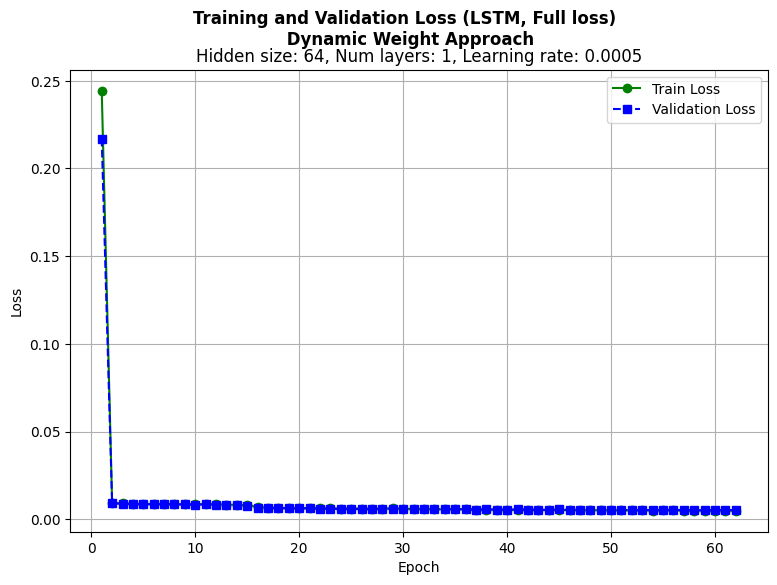

In [13]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(9, 6))
plt.plot(
    epochs,
    train_losses,
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="Green",
)
plt.plot(
    epochs,
    val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="blue",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Full loss) \n Dynamic Weight Approach", weight="bold", size=12)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

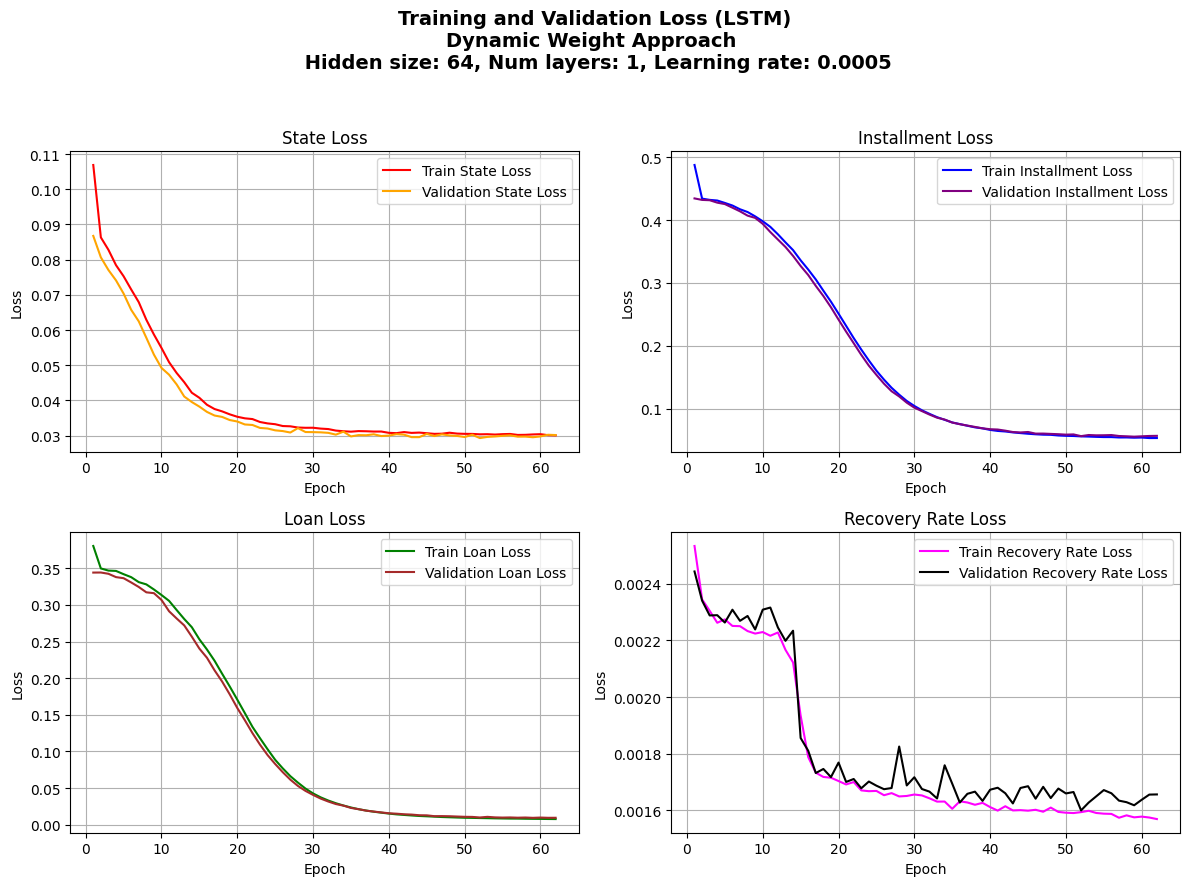

In [14]:
# a plot with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# plot 1: traing_state_loss_list and val_state_loss_list
axs[0, 0].plot(epochs, traing_state_loss_list, label="Train State Loss", color="red")
axs[0, 0].plot(epochs, val_state_loss_list, label="Validation State Loss", color="orange")
axs[0, 0].set_title("State Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# plot 2: training_installment_loss_list and val_installment_loss_list
axs[0, 1].plot(
    epochs, training_installment_loss_list, label="Train Installment Loss", color="blue"
)
axs[0, 1].plot(
    epochs, val_installment_loss_list, label="Validation Installment Loss", color="purple"
)
axs[0, 1].set_title("Installment Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[0, 1].grid(True)

# plot 3: training_loan_loss_list and val_loan_loss_list
axs[1, 0].plot(epochs, training_loan_loss_list, label="Train Loan Loss", color="green")
axs[1, 0].plot(epochs, val_loan_loss_list, label="Validation Loan Loss", color="brown")
axs[1, 0].set_title("Loan Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()
axs[1, 0].grid(True)

# plot 4: training_recovery_rate_loss_list and val_recovery_rate_loss_list
axs[1, 1].plot(
    epochs, training_recovery_rate_loss_list, label="Train Recovery Rate Loss", color="magenta"
)
axs[1, 1].plot(
    epochs, val_recovery_rate_loss_list, label="Validation Recovery Rate Loss", color="black"
)
axs[1, 1].set_title("Recovery Rate Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()
axs[1, 1].grid(True)

# add model parameters to the subtitle
suptitle = f"Dynamic Weight Approach \n Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
plt.suptitle("Training and Validation Loss (LSTM)" + '\n' + suptitle, weight="bold", size=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()